# DSCI 100 Group 14 Final Project
Fahad Alabdulwahed, Anson Chen, Gabriella Muller, Andrew Wong

# Can the player's experience level and age predict whether they are subscribed to the game newsletter?

### Introduction

This project will examine the playing habits of players logged on to Dr. Frank Wood’s Mine Craft server. Dr. Wood’s research group needs to figure out logistics surrounding hosting the server. In this project, we will focus on one specific question that will help Dr. Wood’s team in their recruitment efforts. The dataset has 2 files, `players.csv` and `sessions.csv`, but how question of interest will only utilize `player.csv`. With their broad question of: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?", we will be evaluating whether player's experience level and age can predict the subscription status of players to the game newsletter.

### Dataset
**Player Dataset**: `players.csv`, contains data on each unique player.<br>
Observations: 196, Variables: 7

| Variable|Description|Type|Mean (summary statistic)|
|:--------|:---|:-------|:-----|
|`experience`|experience of a player; Beginner, Amateur, Regular, Pro, Veteran|chr (character)|N/A|
|`subscribe`|if the player is subscribed to the game related newsletter|chr (character)| N/A|
|`hashedEmail`|ID of player|chr (character)| N/A|
|`played_hours`|number of hours played|dbl (numeric value with decimals)|5.845918|	
|`name`|name of the player|chr (character)|N/A|
|`gender`|gender of player|chr (character)|N/A|
|`age`|age of the player|dbl (numeric value with decimals)|21.13918|



# Methods and Results:
## Loading Data into R and Wrangling It

In [18]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(rsample)
library(ggplot2)

In [19]:
players_data <- read_csv("https://raw.githubusercontent.com/ansonansonnn/dsci100-project/refs/heads/main/players.csv")
head(players_data)

players_clean <- players_data|> drop_na()
players_selected <- players_clean|> select(Age, experience, subscribe)
players_selected

summary(players_selected)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Age,experience,subscribe
<dbl>,<chr>,<lgl>
9,Pro,TRUE
17,Veteran,TRUE
17,Veteran,FALSE
21,Amateur,TRUE
21,Regular,TRUE
17,Amateur,TRUE
19,Regular,TRUE
21,Amateur,FALSE
47,Amateur,TRUE


      Age         experience        subscribe      
 Min.   : 9.00   Length:194         Mode :logical  
 1st Qu.:17.00   Class :character   FALSE:52       
 Median :19.00   Mode  :character   TRUE :142      
 Mean   :21.14                                     
 3rd Qu.:22.75                                     
 Max.   :58.00                                     

**Visualization of Exploratory Analysis**

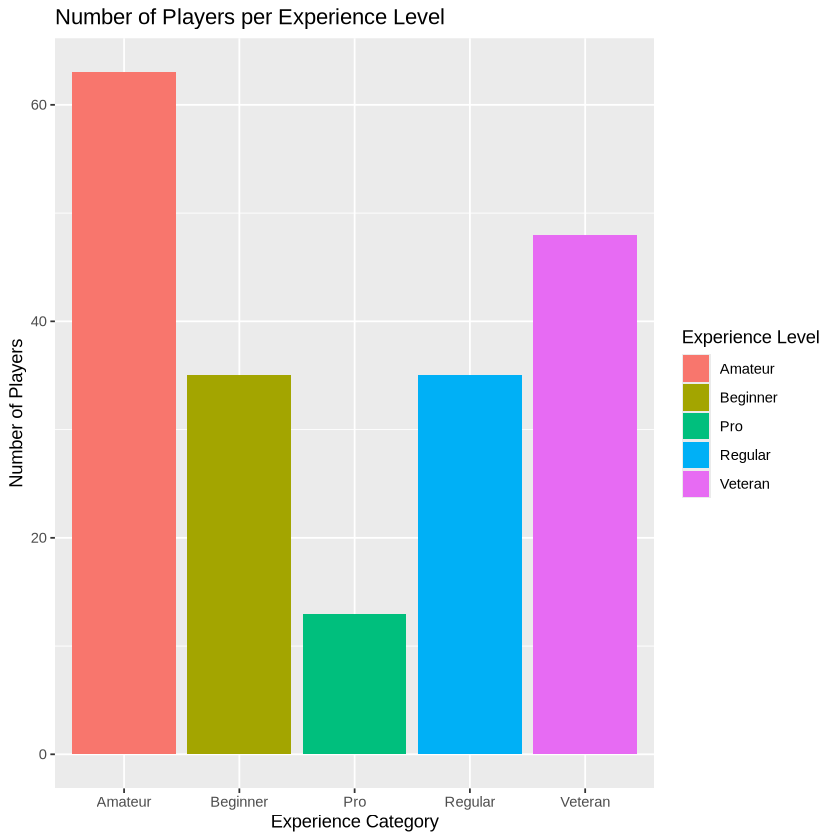

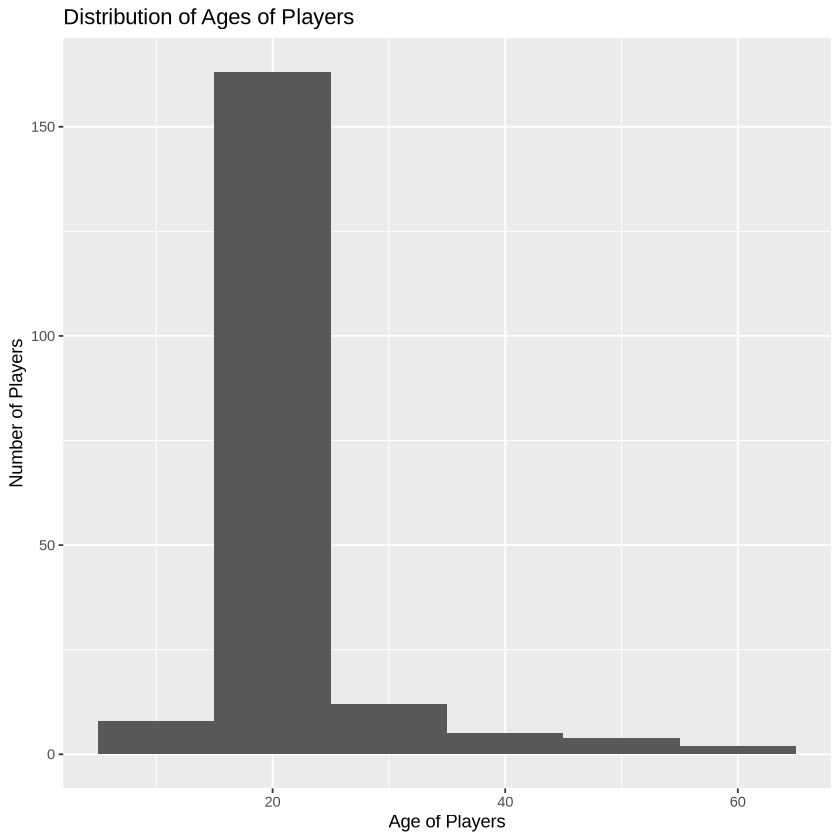

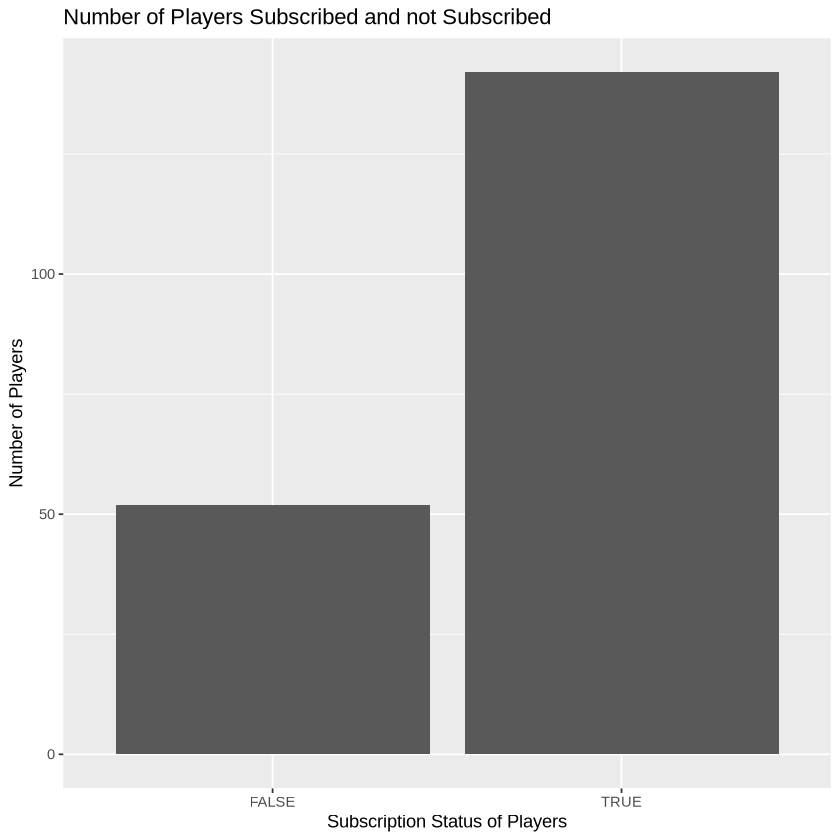

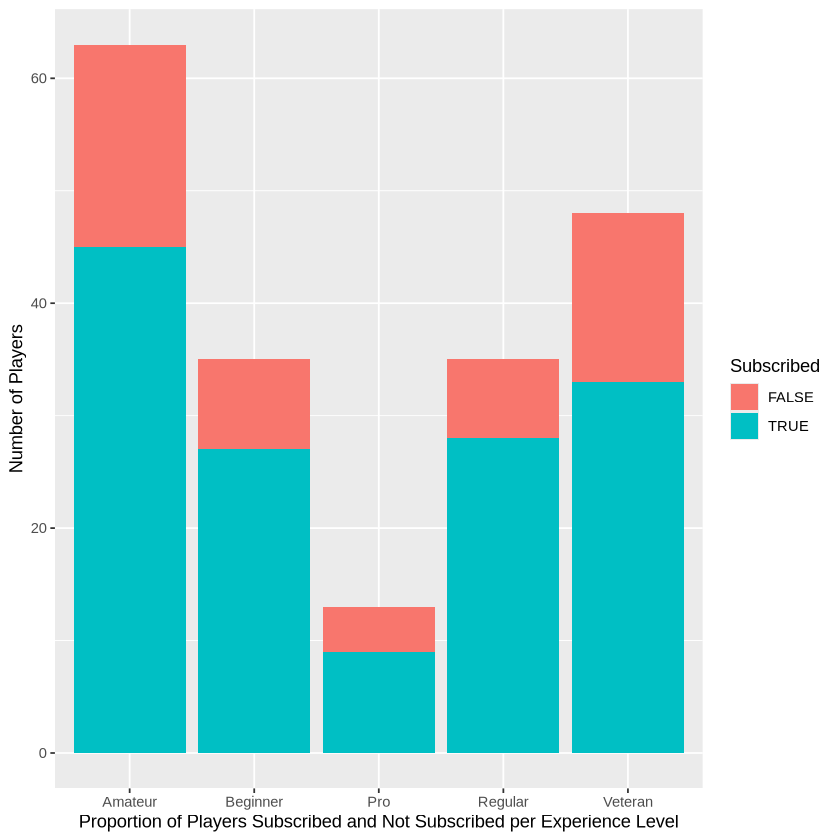

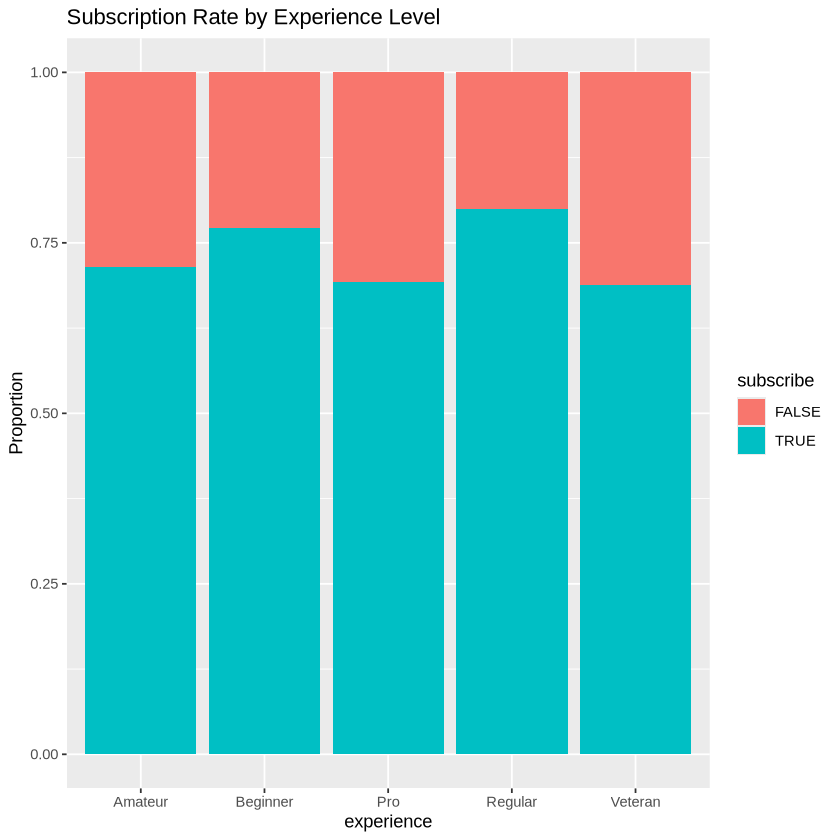

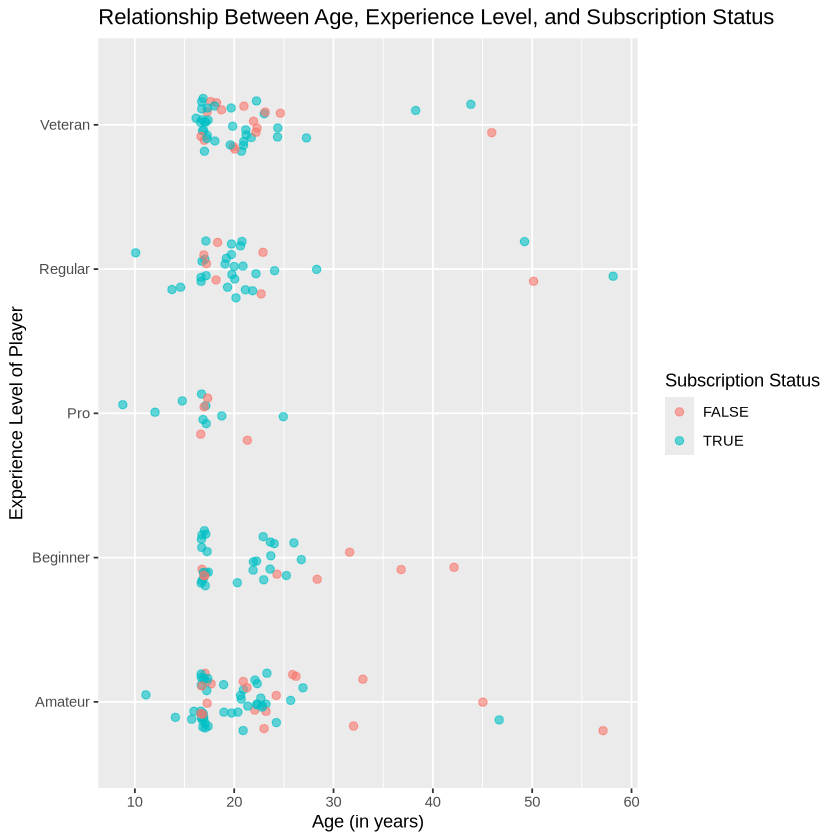

In [20]:
#1) bar plot by experience

experience_plot <- players_selected |>
    ggplot(aes(x = experience, fill = experience))+
    geom_bar(stat = "count")+
    labs(x = "Experience Category",
         y = "Number of Players",
         fill = "Experience Level",
         title = "Number of Players per Experience Level")
experience_plot

#2 distribution (histogram) by age

age_plot <- players_selected |>
    ggplot(aes(x = Age))+
    geom_histogram(binwidth = 10)+
    labs(x = "Age of Players",
         y = "Number of Players",
         title = "Distribution of Ages of Players")
age_plot

#3 bar plot of subsribtion status of players

subscribed_plot <- players_selected |>
    ggplot(aes(x = subscribe))+
    geom_bar()+
    labs(x = "Subscription Status of Players",
         y = "Number of Players",
         title = "Number of Players Subscribed and not Subscribed")
subscribed_plot

#4 bar plot of subscription status and experience proportion

subscribe_experience_plot <- players_selected |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar() +
    labs(x = "Proportion of Players Subscribed and Not Subscribed per Experience Level",
         y = "Number of Players",
         fill = "Subscribed")
subscribe_experience_plot

#5 proportional bar plot of subscription status and experience

players_selected |>
  mutate(experience = as.factor(experience)) |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Subscription Rate by Experience Level",
    y = "Proportion"
  )

#6 jitter plot of subscription status based on age and experience level

all_variables_plot <- ggplot(players_selected, aes(x= Age, y= experience, color= subscribe))+
geom_jitter(height= 0.2, alpha= 0.6, size= 2)+
labs(x= "Age (in years)",
     y= "Experience Level of Player",
     color= "Subscription Status",
     title= "Relationship Between Age, Experience Level, and Subscription Status")
all_variables_plot


**Exploratory Analysis**

In [21]:
players_summarised <- players_selected |>
    summarize( 
        mean_player_age = mean(Age),
        median_player_age = median(Age),
        min_age = min(Age),
        max_age = max(Age))
players_summarised

exp_count <- players_selected |>
    count(experience)
exp_count

sub_count <- players_selected |>
    count(subscribe)
sub_count

mean_player_age,median_player_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>
21.13918,19,9,58


experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,13
Regular,35
Veteran,48


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,142


**Choosing Best K**

In [22]:
set.seed(123)

# Optimal K

players_selected <- players_selected |>
    filter(!is.na(experience)) |>
    mutate(
        subscribe = as.factor(subscribe),
        experience = as.numeric(factor(
            experience,
            levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")
        ))
    )

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

data_split <- initial_split(players_selected, prop = 0.7, strata = subscribe) 
    train_data <- training(data_split)
    test_data  <- testing(data_split)

knn_recipe <- recipe(subscribe ~ Age + experience, data = train_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_wf <- workflow() |>
    add_model(knn_spec) |>
    add_recipe(knn_recipe)

k_grid <- grid_regular(neighbors(range = c(1, 30)), levels = 30)

k_vfold <- vfold_cv(train_data, v = 5)

knn_tuned <- tune_grid(knn_wf, resamples = k_vfold, grid = k_grid, metrics = metric_set(accuracy))

k_select <- select_best(knn_tuned, metric = "accuracy")
k_select


neighbors,.config
<int>,<chr>
11,Preprocessor1_Model11


In [23]:
## andrew draft work

players_selected <- players_data |>
    drop_na() |>
    filter(!is.na(experience), !is.na(Age), !is.na(subscribe)) |>
    select(experience, Age, subscribe)

set.seed(123)
# 1) Wrangle and clean data
# remove NA values, convert categorical predictors to numerical, convert response variable to factor (subscribed or not subscribed)

# convert experience to numeric 
players_selected <- players_selected |> 
    mutate(experience = as.numeric(factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))))

# convert subscribe to factor (subscribed or not subscribed)
players_selected <- players_selected |>
    mutate(subscribe = as.factor(factor(subscribe, levels = c(TRUE, FALSE), labels = c("subscribed", "not subscribed"))))

# splitting the data (train/test)
player_split <- initial_split(players_selected, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

# preprocess the data (create the preprocessing recipe)
player_recipe <- recipe(subscribe ~ Age + experience, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# tune K using cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# split into v folds
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

# create dataframe with values of K to try (1-100)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

best_k <- accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
best_k

# retrain the training data set with best K value

player_recipe <- recipe(subscribe ~ Age + experience, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    fit(data = player_train)

# make predictions and assess accuracy of model on test data
player_test_predictions <- predict(knn_fit, player_test) |>
    bind_cols(player_test)

player_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

[1] 11

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7391304


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9444444


                Truth
Prediction       subscribed not subscribed
  subscribed             34             12
  not subscribed          2              1

**Figure #7: KNN Predicted Classes Scatter Plot**

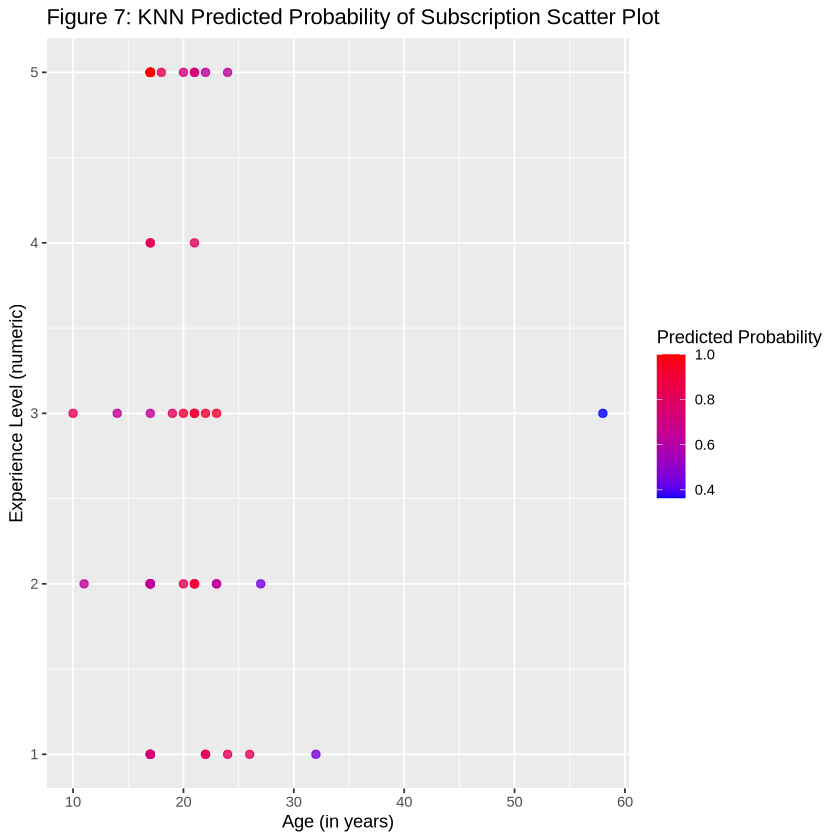

In [30]:

knn_class <- predict(knn_fit, player_test, type= "prob") |>
bind_cols(player_test)

ggplot(knn_class, aes(x= Age, y= experience, color= .pred_subscribed))+
geom_point(size= 2, alpha= 0.8)+
scale_color_gradient(low= "blue", high= "red")+
labs(x= "Age (in years)",
     y= "Experience Level (numeric)",
     color= "Predicted Probability",
     title= "Figure 7: KNN Predicted Probability of Subscription Scatter Plot")

**Figure #7 Analysis:**
Here we see the predicted probability of newsletter subscription generated by the KNN classifier that is using the player's age and experience level as inputs. There are cooler and warmer colors to indicate the likelihood of subscription, cooler colors indicating a lower probability of subscription and warmer colors indicating a higher probability.
There doesn't seem to be a strong correlation between subscription status and experience level since we see higher probabilities of subscribing across all levels, probably indicating that majority of the players were subscribed. Age and subscription status don't seem to relate much either, we only see one outlier at a much higher age than the rest of the players with the lowest probability of subscribing.

**Figure 8: Distribution of KNN Predicted Subscription Probabilities Histogram**

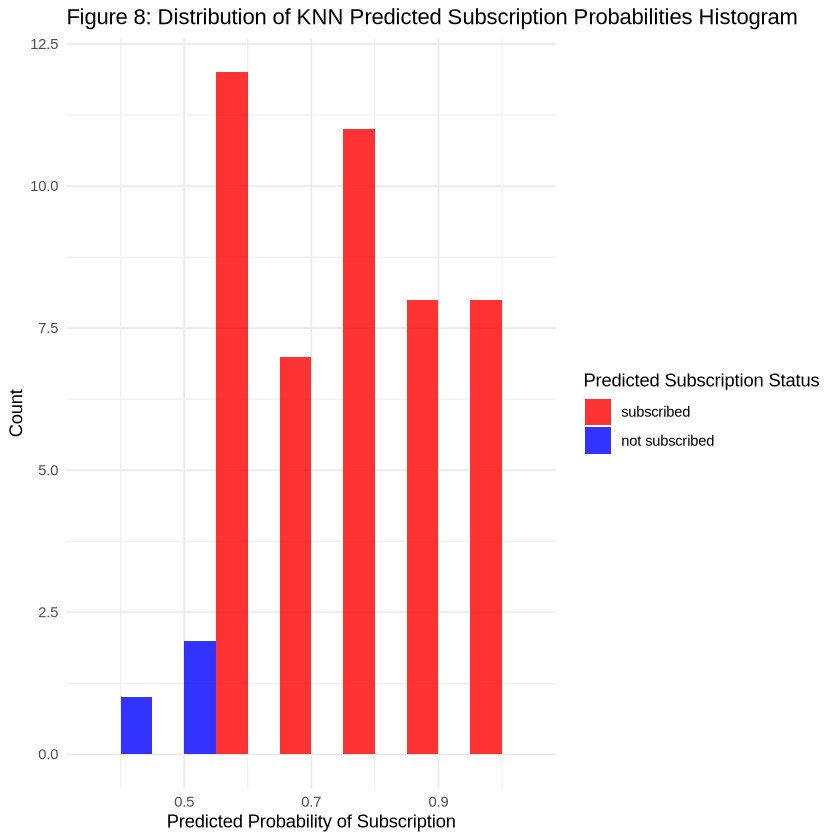

In [35]:
knn_prob <- predict(knn_fit, player_test, type= "prob") |>
bind_cols(player_test) |>
bind_cols(predict(knn_fit, player_test, type = "class"))

ggplot(knn_prob, aes(x= .pred_subscribed, fill= .pred_class))+
geom_histogram(binwidth= 0.1, alpha= 0.8, position= "dodge") +
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
labs(x= "Predicted Probability of Subscription",
     y= "Count",
     fill= "Predicted Subscription Status",
     title= "Figure 8: Distribution of KNN Predicted Subscription Probabilities Histogram")+
theme_minimal()

**Figure 8 Analysis:**
Figure 8 complements figure 7 by showing the distribution of predicted subscription probabilities from the KNN model along with the predicted subscription status of the players. We see the highest probabilities are "subscribed" players, and lower probabilities are "not subscribed" players, indicating the KNN model is more likely to classify more players as subscribed. 

**Figure 9: Distribution of Player Age by Subscription Status Boxplot**

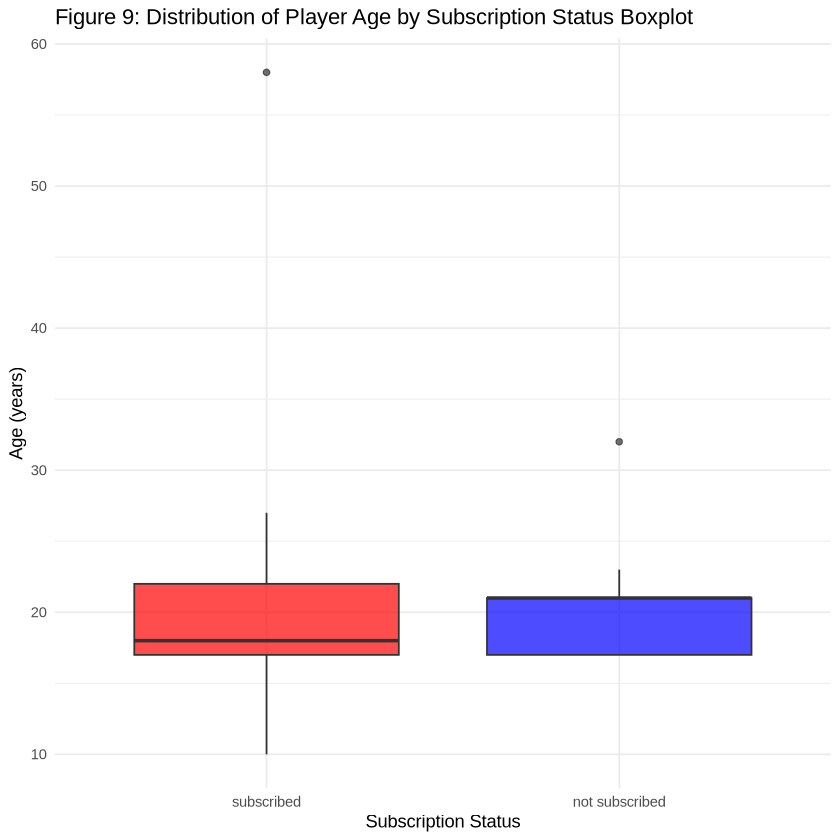

In [36]:
ggplot(player_test, aes(x= subscribe, y= Age, fill= subscribe))+
geom_boxplot(alpha= 0.7)+
labs(x= "Subscription Status",
     y= "Age (years)",
     title= "Figure 9: Distribution of Player Age by Subscription Status Boxplot")+
theme_minimal()+
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
theme(legend.position= "none")

**Figure 9 Analysis:**
Here we see a boxplot showing the distribution of player ages, grouped by their subscription status to the newsletter. We see the median age between both subscribed and not subscribed is rather similar, so age might not be the strongest predictor of player subscription. There are older players who are outliers in the subscribed group, but overall the boxplot shows us that age varies among players and may not be the best insight in predicting subscription status.

**Figure 10: Distribution of Player Experience by Subscription Status Boxplot**

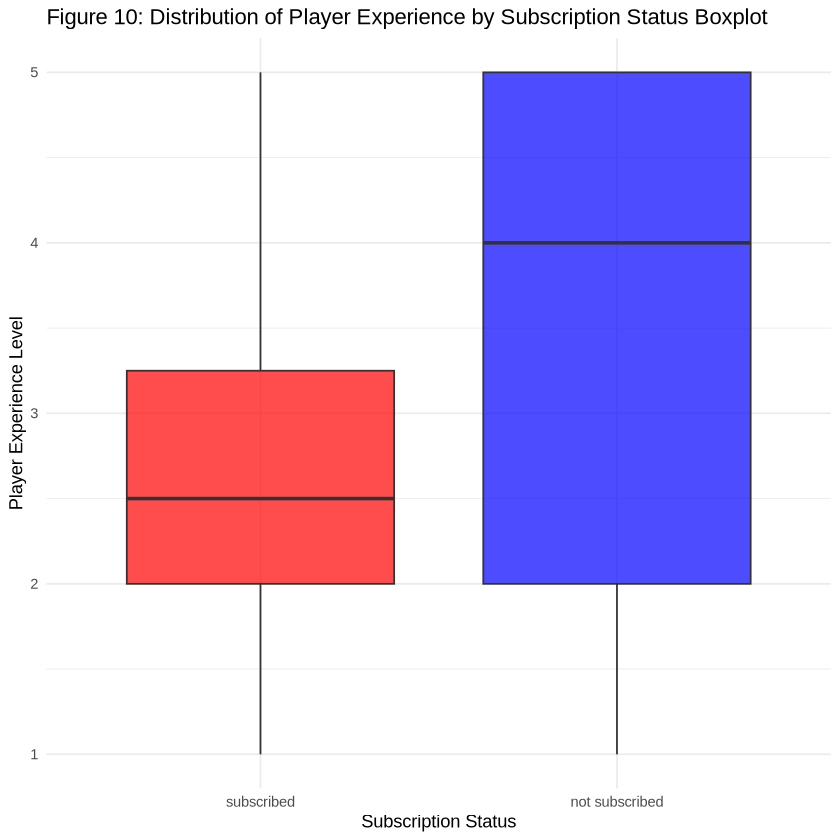

In [37]:
ggplot(player_test, aes(x= subscribe, y= experience, fill= subscribe))+
geom_boxplot(alpha= 0.7)+
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
labs(x= "Subscription Status",
     y= "Player Experience Level",
     title= "Figure 10: Distribution of Player Experience by Subscription Status Boxplot")+
theme_minimal()+
theme(legend.position = "none")

**Figure 10 Analysis:**
In this boxplot we see the distribution of player experience levels grouped by the player's subscription status. We can see that the median experience level for not subscribed players is higher than the experience levels of subscribed players, the not subscribed experience levels also spread across a wider range of levels than subscribed players. This shows that this may be a stronger predictor of subscription status than age is. 